<a href="https://colab.research.google.com/github/brenttoast/C964_Project/blob/main/C964_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ipywidgets import interact, widgets
import requests
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import json

Download and process data files

In [ ]:
data_folder = 'https://raw.githubusercontent.com/brenttoast/C964_Project/main/data/'
radio_json = [
    'noc_bmd.json',
    'noc_bv.json',
    'noc_col.json',
    'noc_gwt.json',
    'noc_he.json',
    'noc_hg.json',
    'noc_hw.json',
    'noc_sar.json',
    'noc_tt.json',
    'noc_tur.json'
]

def json_download(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

train_temperature = json_download(f'{data_folder}temp_galt.json')
train_temperature = pd.DataFrame(train_temperature).rename(columns={"dt": "time"})
train_temperature = train_temperature[['time', 'main']]
train_temperature['temp'] = train_temperature['main'].apply(lambda x: x['temp'])
train_temperature = train_temperature[['time', 'temp']]
train_temperature['time'] = pd.to_datetime(train_temperature['time'], unit='s')
train_temperature['time'] = train_temperature['time'].dt.tz_localize('Etc/GMT+2')
print(train_temperature)

radio_stats_all = []

for json_file in radio_json:
    radio_info = json_download(f'{data_folder}{json_file}')
    azimuth = radio_info['meta']['azimuth']
    height = radio_info['meta']['height']
    radio_info = pd.DataFrame(radio_info["data"]).rename(columns={"sensor": "rsl"})
    radio_info['time'] = pd.to_datetime(radio_info['time'], format='%Y-%m-%d %H:%M:%S')
    radio_info['time'] = radio_info['time'].dt.tz_localize('US/Pacific')
    radio_info = pd.merge(radio_info, train_temperature, on='time')
    radio_info['rsl_delta'] = abs(radio_info['rsl'] - stats.mode(radio_info['rsl'])[0])
    radio_info['azimuth'] = azimuth
    radio_info['azimuth_sin'] = np.sin(np.radians(azimuth))
    radio_info['azimuth_cos'] = np.cos(np.radians(azimuth))
    radio_info['height'] = height
    radio_stats_all.extend(radio_info.to_dict(orient='records'))

df = pd.DataFrame(radio_stats_all)

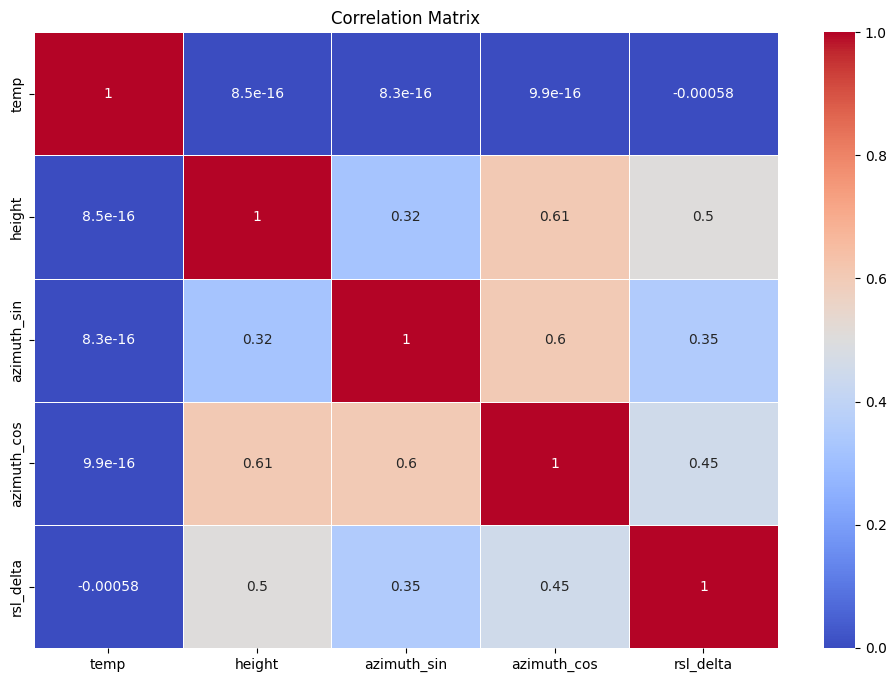

In [41]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[['temp', 'height', 'azimuth_sin', 'azimuth_cos', 'rsl_delta']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

                         time   temp
0   2024-05-11 00:00:00-02:00  32.84
1   2024-05-11 01:00:00-02:00  32.22
2   2024-05-11 02:00:00-02:00  31.03
3   2024-05-11 03:00:00-02:00  23.74
4   2024-05-11 04:00:00-02:00  23.44
..                        ...    ...
163 2024-05-17 19:00:00-02:00  22.16
164 2024-05-17 20:00:00-02:00  23.95
165 2024-05-17 21:00:00-02:00  25.05
166 2024-05-17 22:00:00-02:00  26.54
167 2024-05-17 23:00:00-02:00  27.76

[168 rows x 2 columns]



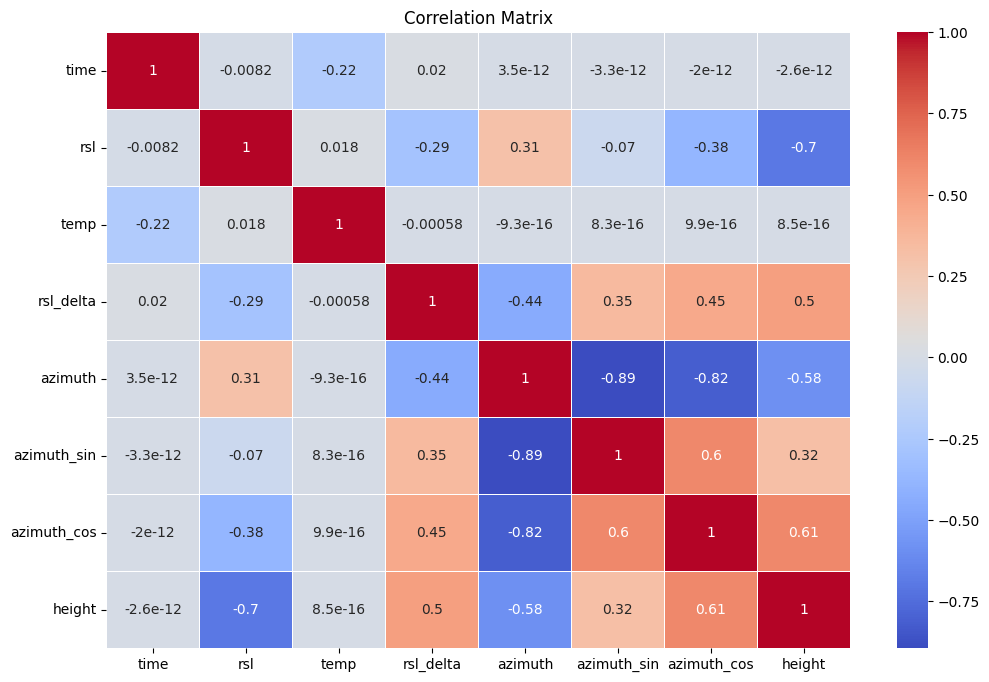

MAE: 0.38524155888521805
MSE: 0.3126170857337073
R^2: 0.8583382023018173


In [16]:
X = df[['temp', 'height', 'azimuth_sin', 'azimuth_cos']]
y = (df['rsl_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

model = model.best_estimator_

y_prediction = model.predict(X_test)

mae = mean_absolute_error(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

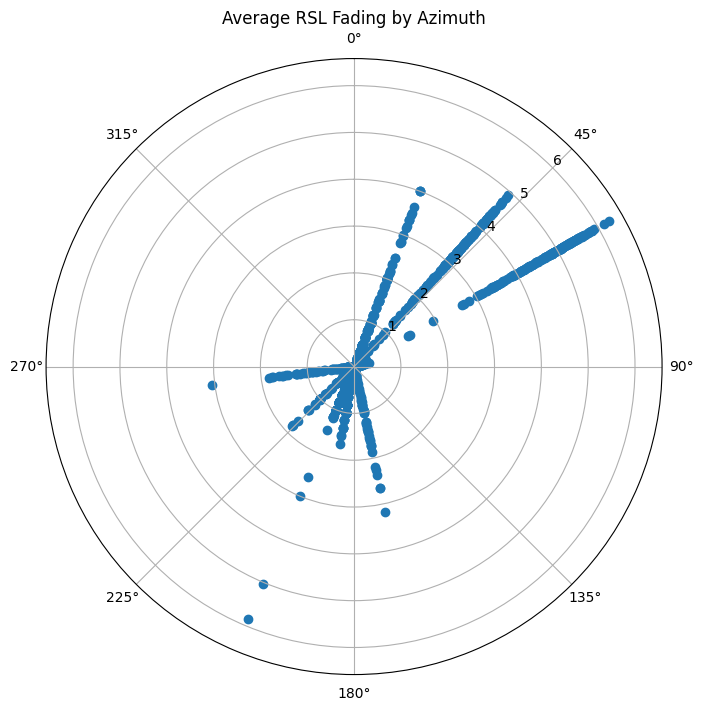

In [39]:
# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

# Convert azimuth to radians
theta = np.deg2rad(df['azimuth'])

# Plot the data
ax.scatter(theta, df['rsl_delta'], marker='o')

# Set labels and title
ax.set_theta_zero_location("N")  # Set North at the top
ax.set_theta_direction(-1)  # Clockwise direction
ax.set_rlabel_position(45)  # Adjust radial label position
plt.title("Average RSL Fading by Azimuth")

# Show the plot
plt.show()

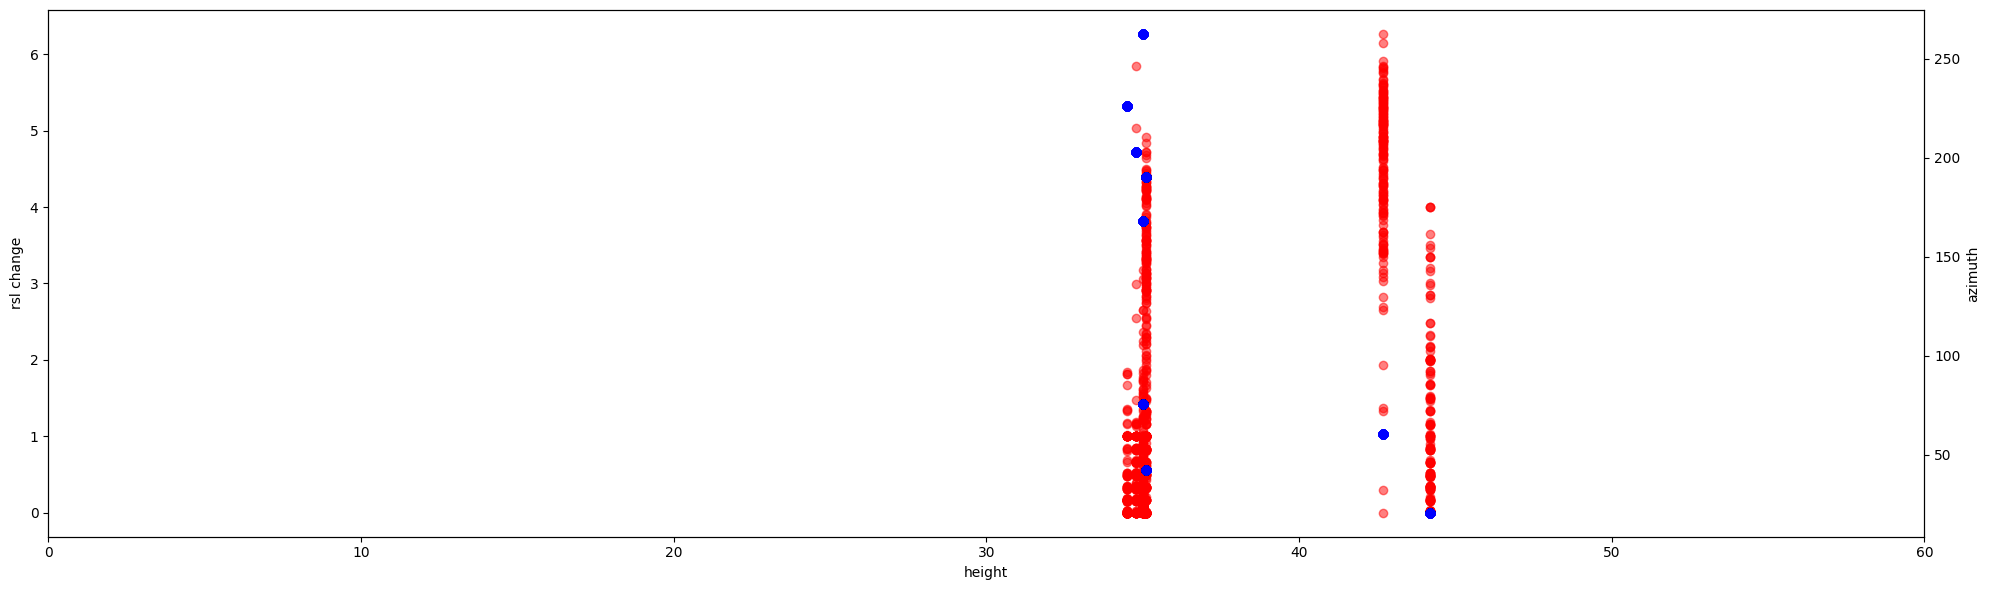

In [32]:
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.scatter(df['height'], df['rsl_delta'], alpha=0.5, label='rsl', color='red')
ax1.set_xlabel('height')
ax1.set_ylabel('rsl change')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.scatter(df['height'], df['azimuth'], alpha=0.5, label='temp', color='blue')
ax2.set_ylabel('azimuth')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.xlim(0,60)
plt.show()

In [31]:
def plot_rsl_change(input_height=35, input_azimuth=0):
    temperatures = np.arange(10, 35, 1)
    predicted_rsl = []

    for temp in temperatures:
        inputs = pd.DataFrame({
            'temp': [temp], 'height': [input_height],
            'azimuth_sin': [np.sin(np.radians(input_azimuth))],
            'azimuth_cos': [np.cos(np.radians(input_azimuth))],
        })
        predicted_rsl.append(model.predict(inputs)[0])

    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, predicted_rsl)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Potential RSL Change (dBm)')
    plt.yticks(np.arange(0, 5, 0.5))
    plt.ylim(0, 5)
    plt.title(f'RSL Change vs. Temperature (Height: {input_height}m, Azimuth: {input_azimuth}°)')
    plt.grid(True)
    plt.show()


interact(plot_rsl_change,
         input_height=widgets.IntSlider(min=30, max=60, step=1, value=35, description='Height (m)'),
         input_azimuth=widgets.IntSlider(min=0, max=360, step=1, value=0, description='Azimuth (°)'))


interactive(children=(IntSlider(value=35, description='Height (m)', max=60, min=30), IntSlider(value=0, descri…

<function __main__.plot_rsl_change(input_height=35, input_azimuth=0)>